In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import Pool
import lightgbm as lgb
from xgboost import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV
from  sklearn.metrics import mean_absolute_error,r2_score
from keras.models import Sequential
from keras.layers import Dense,Dropout,GRU
from keras.callbacks import EarlyStopping

In [4]:
train=pd.read_csv("/content/drive/My Drive/trafficflow_dataset/train.csv")

In [5]:
train.head()

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [6]:
test=pd.read_csv("/content/drive/My Drive/trafficflow_dataset/test.csv")

In [7]:
test.head()

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB


In [8]:
train.describe()

,row_id,x,y,congestion
count,848835.000000,848835.000000,848835.000000,848835.000000
mean,424417.000000,1.138462,1.630769,47.815305
std,245037.702211,0.801478,1.089379,16.799392
min,0.000000,0.000000,0.000000,0.000000
25%,212208.500000,0.000000,1.000000,35.000000
50%,424417.000000,1.000000,2.000000,47.000000
75%,636625.500000,2.000000,3.000000,60.000000
max,848834.000000,2.000000,3.000000,100.000000


In [9]:
train['direction'].unique()

array(['EB', 'NB', 'SB', 'WB', 'NE', 'SW', 'NW', 'SE'], dtype=object)

<BarContainer object of 101 artists>

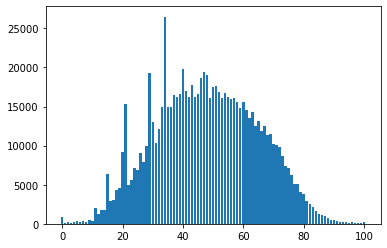

In [10]:
plt.bar(range(101),train['congestion'].value_counts().sort_index())

In [11]:
train.isnull().sum()

row_id        0
time          0
x             0
y             0
direction     0
congestion    0
dtype: int64

In [12]:
lab_en=preprocessing.LabelEncoder()

In [13]:
train['direction']=lab_en.fit_transform(train['direction'])

In [14]:
def date_(x):
  return x.split()[0]

In [15]:
train['dat']=train['time'].apply(date_)

In [16]:
def time_(x):
  return x.split()[1]

In [17]:
train['time']=train['time'].apply(time_)

In [18]:
test['time']=test['time'].apply(time_)

In [19]:
def hr_(x):
  return int(x.split(':')[0])
def min_(x):
  return int(x.split(':')[1])

In [20]:
train['hour']=train['time'].apply(hr_)
train['minutes']=train['time'].apply(min_)

In [21]:
test['hour']=test['time'].apply(hr_)
test['minutes']=test['time'].apply(min_)

In [22]:
train.head(3)

,row_id,time,x,y,direction,congestion,dat,hour,minutes
0,0,00:00:00,0,0,0,70,1991-04-01,0,0
1,1,00:00:00,0,0,1,49,1991-04-01,0,0
2,2,00:00:00,0,0,4,24,1991-04-01,0,0


In [23]:
train.head(3)

,row_id,time,x,y,direction,congestion,dat,hour,minutes
0,0,00:00:00,0,0,0,70,1991-04-01,0,0
1,1,00:00:00,0,0,1,49,1991-04-01,0,0
2,2,00:00:00,0,0,4,24,1991-04-01,0,0


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   row_id      848835 non-null  int64 
 1   time        848835 non-null  object
 2   x           848835 non-null  int64 
 3   y           848835 non-null  int64 
 4   direction   848835 non-null  int64 
 5   congestion  848835 non-null  int64 
 6   dat         848835 non-null  object
 7   hour        848835 non-null  int64 
 8   minutes     848835 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 58.3+ MB


In [25]:
train.info 

<bound method DataFrame.info of         row_id      time  x  y  direction  congestion         dat  hour  \
0            0  00:00:00  0  0          0          70  1991-04-01     0   
1            1  00:00:00  0  0          1          49  1991-04-01     0   
2            2  00:00:00  0  0          4          24  1991-04-01     0   
3            3  00:00:00  0  1          0          18  1991-04-01     0   
4            4  00:00:00  0  1          1          60  1991-04-01     0   
...        ...       ... .. ..        ...         ...         ...   ...   
848830  848830  11:40:00  2  3          1          54  1991-09-30    11   
848831  848831  11:40:00  2  3          2          28  1991-09-30    11   
848832  848832  11:40:00  2  3          4          68  1991-09-30    11   
848833  848833  11:40:00  2  3          6          17  1991-09-30    11   
848834  848834  11:40:00  2  3          7          24  1991-09-30    11   

        minutes  
0             0  
1             0  
2            

In [26]:
train["dat"] = pd.to_datetime(train["dat"])

In [27]:
from datetime import datetime
train['dayOfWeek'] = train['dat'].dt.weekday

In [28]:
train.head()

,row_id,time,x,y,direction,congestion,dat,hour,minutes,dayOfWeek
0,0,00:00:00,0,0,0,70,1991-04-01,0,0,0
1,1,00:00:00,0,0,1,49,1991-04-01,0,0,0
2,2,00:00:00,0,0,4,24,1991-04-01,0,0,0
3,3,00:00:00,0,1,0,18,1991-04-01,0,0,0
4,4,00:00:00,0,1,1,60,1991-04-01,0,0,0


In [29]:
train.tail()

,row_id,time,x,y,direction,congestion,dat,hour,minutes,dayOfWeek
848830,848830,11:40:00,2,3,1,54,1991-09-30,11,40,0
848831,848831,11:40:00,2,3,2,28,1991-09-30,11,40,0
848832,848832,11:40:00,2,3,4,68,1991-09-30,11,40,0
848833,848833,11:40:00,2,3,6,17,1991-09-30,11,40,0
848834,848834,11:40:00,2,3,7,24,1991-09-30,11,40,0


In [30]:
x=train[["hour","minutes","dayOfWeek"]]
y=train["congestion"]

In [31]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.3) 

In [51]:
lgb_params = {
    "objective" : "regression",
    "metric": "mae",
    'boosting': "gbdt",  
    "learning_rate": 0.05,
    "num_leaves": 20, 
    "max_depth": 7,
                   }
def model_fit(x_train,y_train,x_test,y_test,test_df=None):
   train_data = lgb.Dataset(x_train, label=y_train)
   val_data = lgb.Dataset(x_test, label=y_test)
   model1= lgb.train(params=lgb_params,
                      train_set= train_data, 
                      valid_sets= [val_data], 
                      num_boost_round= 50,
                     ) 
   train_preds =model1.predict(x_test)
   mae = mean_absolute_error(y_test, train_preds)
   print( mae)
   print(r2_score(y_test, train_preds)) 
    
   return train_preds, mae, model1

train_preds,  mae ,model1= model_fit(x_train, y_train, x_test, y_test, None)

[1]	valid_0's l1: 13.8411
[2]	valid_0's l1: 13.8074
[3]	valid_0's l1: 13.7759
[4]	valid_0's l1: 13.748
[5]	valid_0's l1: 13.7236
[6]	valid_0's l1: 13.7009
[7]	valid_0's l1: 13.6796
[8]	valid_0's l1: 13.6605
[9]	valid_0's l1: 13.6427
[10]	valid_0's l1: 13.6264
[11]	valid_0's l1: 13.6131
[12]	valid_0's l1: 13.601
[13]	valid_0's l1: 13.5896
[14]	valid_0's l1: 13.5782
[15]	valid_0's l1: 13.568
[16]	valid_0's l1: 13.5587
[17]	valid_0's l1: 13.5503
[18]	valid_0's l1: 13.5428
[19]	valid_0's l1: 13.536
[20]	valid_0's l1: 13.5296
[21]	valid_0's l1: 13.5239
[22]	valid_0's l1: 13.5184
[23]	valid_0's l1: 13.5137
[24]	valid_0's l1: 13.509
[25]	valid_0's l1: 13.505
[26]	valid_0's l1: 13.5009
[27]	valid_0's l1: 13.4975
[28]	valid_0's l1: 13.4943
[29]	valid_0's l1: 13.4914
[30]	valid_0's l1: 13.4885
[31]	valid_0's l1: 13.4861
[32]	valid_0's l1: 13.484
[33]	valid_0's l1: 13.4817
[34]	valid_0's l1: 13.4797
[35]	valid_0's l1: 13.4778
[36]	valid_0's l1: 13.4762
[37]	valid_0's l1: 13.4746
[38]	valid_0's l1

In [46]:
import pickle

In [52]:
pickle.dump(model1, open('traffic_model.pkl', 'wb'))

In [33]:
CBC = CatBoostRegressor()
parameters = {'depth'         : [4,5,6,7,8,9, 10],'learning_rate' : [0.01,0.02,0.03,0.04],'iterations': [10, 20,30,40,50,60,70,80,90, 100]}
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(x_train, y_train)
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

0:	learn: 16.7551907	total: 129ms	remaining: 12.8s
1:	learn: 16.7176174	total: 207ms	remaining: 10.2s
2:	learn: 16.6832019	total: 287ms	remaining: 9.29s
3:	learn: 16.6512154	total: 368ms	remaining: 8.82s
4:	learn: 16.6224551	total: 440ms	remaining: 8.36s
5:	learn: 16.5968180	total: 506ms	remaining: 7.93s
6:	learn: 16.5718294	total: 582ms	remaining: 7.73s
7:	learn: 16.5490638	total: 664ms	remaining: 7.64s
8:	learn: 16.5273530	total: 746ms	remaining: 7.54s
9:	learn: 16.5071564	total: 831ms	remaining: 7.47s
10:	learn: 16.4880762	total: 915ms	remaining: 7.4s
11:	learn: 16.4707620	total: 987ms	remaining: 7.24s
12:	learn: 16.4545247	total: 1.06s	remaining: 7.12s
13:	learn: 16.4397018	total: 1.14s	remaining: 6.97s
14:	learn: 16.4265719	total: 1.21s	remaining: 6.83s
15:	learn: 16.4137025	total: 1.28s	remaining: 6.71s
16:	learn: 16.4017341	total: 1.35s	remaining: 6.6s
17:	learn: 16.3906335	total: 1.42s	remaining: 6.49s
18:	learn: 16.3801328	total: 1.5s	remaining: 6.39s
19:	learn: 16.3709447	tot

In [34]:

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True) 

xgb_grid.fit(x_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


KeyboardInterrupt: ignored

In [39]:
model=XGBRegressor(colsample_bytree=0.7,learning_rate= 0.03, max_depth= 5, min_child_weight=4, n_estimators= 500, nthread= 4, objective= 'reg:linear', silent= 1, subsample=0.7)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print(mean_absolute_error(y_pred,y_test))

13.450251855409093


In [40]:

r=r2_score(y_pred,y_test)
r

-13.52047819135957

In [42]:
mod=CatBoostRegressor(depth=10, iterations= 100, learning_rate= 0.04)
mod.fit(x_train,y_train)
ypred=model.predict(x_test)
r=r2_score(y_pred,y_test)

0:	learn: 16.7551907	total: 190ms	remaining: 18.8s
1:	learn: 16.7176174	total: 395ms	remaining: 19.4s
2:	learn: 16.6832019	total: 584ms	remaining: 18.9s
3:	learn: 16.6512154	total: 792ms	remaining: 19s
4:	learn: 16.6224551	total: 950ms	remaining: 18.1s
5:	learn: 16.5968180	total: 1.11s	remaining: 17.4s
6:	learn: 16.5718294	total: 1.27s	remaining: 16.9s
7:	learn: 16.5490638	total: 1.44s	remaining: 16.5s
8:	learn: 16.5273530	total: 1.61s	remaining: 16.3s
9:	learn: 16.5071564	total: 1.8s	remaining: 16.2s
10:	learn: 16.4880762	total: 1.99s	remaining: 16.1s
11:	learn: 16.4707620	total: 2.16s	remaining: 15.8s
12:	learn: 16.4545247	total: 2.31s	remaining: 15.4s
13:	learn: 16.4397018	total: 2.48s	remaining: 15.3s
14:	learn: 16.4265719	total: 2.62s	remaining: 14.8s
15:	learn: 16.4137025	total: 2.76s	remaining: 14.5s
16:	learn: 16.4017341	total: 2.96s	remaining: 14.5s
17:	learn: 16.3906335	total: 3.27s	remaining: 14.9s
18:	learn: 16.3801328	total: 3.52s	remaining: 15s
19:	learn: 16.3709447	total

In [44]:
mean=mean_absolute_error(y_pred,y_test)
mean

13.450251855409093

In [45]:
r

-13.52047819135957